<a href="https://colab.research.google.com/github/Hyouka72/PythonLearning/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#To predict Heart Disease By using Neural Network Model
#Neutral Network = Human Brain
##@ Setup + Imports
#for handling data
import numpy as np
import pandas as pd
#for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
#for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
#for splitting data and evaluating models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from google.colab import userdata
import os


In [ ]:
#Using API to Access the DataSet
from google.colab import userdata
key= userdata.get('kaggle_key')
name= userdata.get('kaggle_username')

In [ ]:
# Set Kaggle credentials
os.environ["KAGGLE_USERNAME"] = userdata.get('kaggle_username')
os.environ["KAGGLE_KEY"] = userdata.get('kaggle_key')

# Download and unzip dataset
!kaggle datasets download -d fedesoriano/heart-failure-prediction
!unzip -o heart-failure-prediction.zip


Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
heart-failure-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  heart-failure-prediction.zip
  inflating: heart.csv               


In [ ]:
##@ Data Prep
# Load data
df = pd.read_csv("heart.csv")

# Check for categorical columns
print("Categorical columns:", df.select_dtypes(include='object').columns.tolist())

# Encode categorical columns
#just converting Male Female into numeric value i.e, 0 and 1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Separate features and target
X = df.drop("HeartDisease", axis=1) # this in input
y = df["HeartDisease"] # this is output

# Scale features
scaler = StandardScaler() # normal scaling to make the data set mean=0 and S.D=1
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1) # Converting 1D into 2D column vector, used -1 becouse it helps to allocate columne automatically

# Split data
#Used 80/20 rule 80 percent for training and 20 for testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Train/Test shapes: torch.Size([734, 11]) torch.Size([184, 11])


In [ ]:
##@ Training - Neural Network
class HeartNet(nn.Module):
    def __init__(self, input_size):
        super(HeartNet, self).__init__()
        #input layer 64
        self.layer1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU() #Relu is the method used in this nn
        #hidden layer 32
        self.layer2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()  #Relu is the method used in this nn
        #output layer1
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid() #Sigmoid is the method used in this nn since it gives only output in O and 1

#this the where the actual web is created, the web of neutral network
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

# Initialize model, loss, and optimizer
model = HeartNet(input_size=X_train.shape[1]) # give the no. of column, i.e, no.of per sample
criterion = nn.BCELoss() #loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) #Updates the model to reduce the loss and learning rate

# Train model
epochs = 50
train_losses = []
val_losses = []

#This one is again to split that 20% into 50/50 hence the 10% for the test and 10% for validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Training start accordind to no. of epochs
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

#this evalutation takes the 10% as X_val of separated 20% data(not used for the training)
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss.item():.4f}")



Epoch [10/50], Loss: 0.6541
Epoch [20/50], Loss: 0.5877
Epoch [30/50], Loss: 0.5152
Epoch [40/50], Loss: 0.4443
Epoch [50/50], Loss: 0.3893


In [ ]:
# Evaluate model
#this evalutation takes the separated 10% data.i.e the X_test(Not used for the training)
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred > 0.5).float()
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Neural Network Accuracy: {accuracy:.4f}")


Neural Network Accuracy: 0.8478


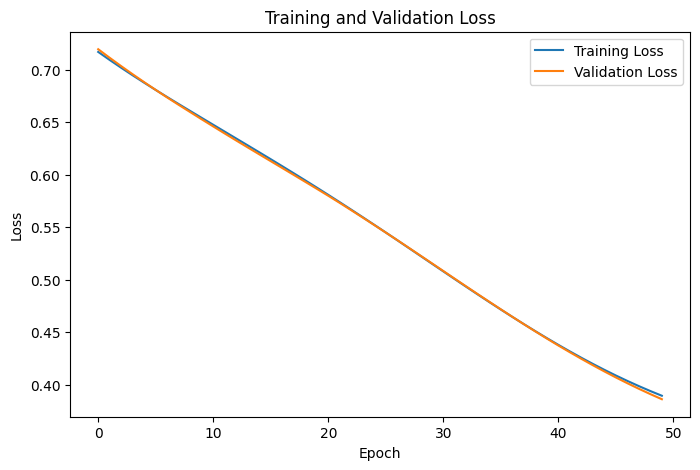

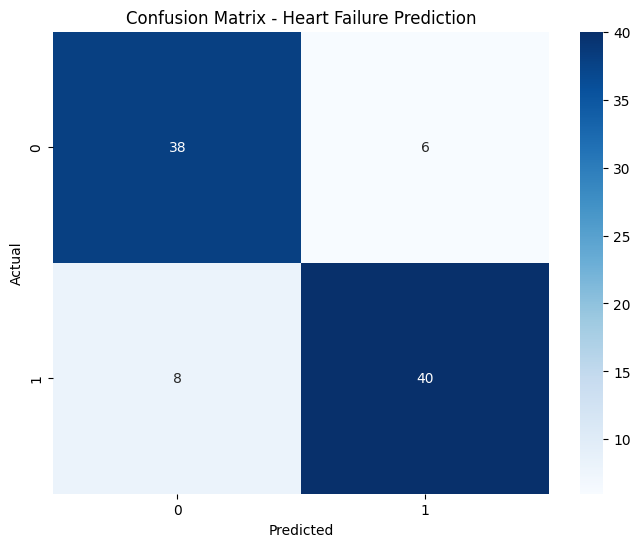

In [ ]:
##@ Visualization - Training Progress
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##@ Visualization - Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Heart Failure Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Here I learn that Training means How well the Machine is learning from the data
#And in case of Validation loss it means how well is Machine able to predict in new data
#Since both Validation loss and Training loss are decresing it means the model is trained well

HERE

TP is 40 and TF is 40


FP is 6 and FN is 8

True Positive= means the paitient have heart diesease and model also predicated it true

True Negative= means the paitient don't have heart diesease and model also predicated it false

False Positive= means the paitient don't have heart diesease but model predicated it true

False Negative= means the paitient have heart diesease but model predicated as false